# 04_first_visuals
Developing first steps to an anomaly detection algorithm with visualisations


## Import packages

In [90]:
import sys
import os

import yaml
import pandas as pd
import numpy as np
from sqlalchemy import create_engine

import seaborn as sns
import matplotlib.pyplot as plt

from bokeh.plotting import figure,save, output_file, show
from bokeh.tile_providers import CARTODBPOSITRON, get_provider
from bokeh.models import ColumnDataSource
from bokeh.palettes import Category10

from sklearn.preprocessing import MinMaxScaler

from functions.utils import get_folder
from functions.data_loads import get_columns, load_data


pd.set_option('display.float_format', '{:.2f}'.format)

curr_folder = get_folder()
parent_fold = curr_folder.parent
with open(parent_fold / "connections.yml", encoding='utf-8') as file:
    db_config = yaml.safe_load(file)
    
with open(parent_fold / "configurations" / "data_loads.yaml", encoding='utf-8') as file:
    column_conf = yaml.safe_load(file)
    
engine = create_engine(f'postgresql+psycopg2://{db_config["user"]}:{db_config["password"]}@{db_config["host"]}:{db_config["port"]}/{db_config["db"]}')

dates = ["01.05.2022","05.05.2022"]

## define functions

In [105]:
def visualize_top_regions(data,columns={'lat':'lat_merc_x','lon':'lon_merc_x','size':'mmsi_nunique'}, titel="Most Busy Regions in Norway"):
    """
    This function creates a plot which visualises the top regions in norway
    """
    tile_provider = get_provider(CARTODBPOSITRON)
    
    MinMax = MinMaxScaler(feature_range=(1,40))
    train = data[columns['size']].to_numpy().reshape(-1,1)
    data[columns['size']] = MinMax.fit_transform(train)
    p = figure(title=titel, plot_width=800, plot_height=700,
           x_range=(1500000, 1700000), y_range=(7000000, 12000000),
           x_axis_type="mercator", y_axis_type="mercator")
    p.add_tile(tile_provider)
    p.circle(x=data[columns['lat']], y=data[columns['lon']], size=data[columns['size']], color="red", fill_alpha=1)
    return p

def  bar_chart(data, columns={'x':'dow','values':'mmsi_nunique'},titel="Most Busy Days"):
    """
    A Short function to create a bar plot which is showing the data
    
    """
    if columns['x'] == 'dow':
        replacer = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
        data.replace({columns['x']:replacer},inplace=True)
        print(data)
    p = figure(x_range=data[columns['x']],plot_width=800, plot_height=700,title=titel )
    p.vbar(x=data[columns['x']],top=data[columns['values']],color=Category10[7])
    p.xgrid.grid_line_color = None
    p.y_range.start = 0
    
    return p

In [4]:
columns = get_columns(engine,'tbl_positionagg',column_conf['position_unrel_cols'])
print(columns)
data = load_data(engine,'tbl_positionagg',columns)
data['msgtime'] = pd.to_datetime(data['msgtime'])
data[['lat_merc_x','lon_merc_x']] = data[['lat_merc_x','lon_merc_x']].round(2)

['aisclass_count', 'aisclass_count_l_hour', 'date', 'dow', 'hod', 'lat_merc_x', 'lat_merc_y', 'lon_merc_x', 'lon_merc_y', 'mmsi_nunique', 'mmsi_nunique_l_hour', 'msgtime', 'sog_max', 'sog_max_l_hour', 'sog_mean', 'sog_mean_l_hour', 'sog_min', 'sog_min_l_hour', 'sog_std', 'sog_std_l_hour']


In [7]:
data[['lat_merc_x','lon_merc_x','aisclass_count']].groupby(['lat_merc_x','lon_merc_x']).sum().sort_values(['aisclass_count'],ascending=False)

aisclass_count
lat_merc_x lon_merc_x                 
589993.30  8489337.03           263927
634521.10  8180386.89           225842
1191118.55 8377507.56           192763
2115070.33 10971767.97          192198
857160.08  9124813.24           160416
...                                ...
1970354.99 13331165.43               1
           13611218.89               1
1981486.94 10476778.07               1
           10876182.95               1
1447153.38 11003930.41               1

[20100 rows x 1 columns]

## test data set

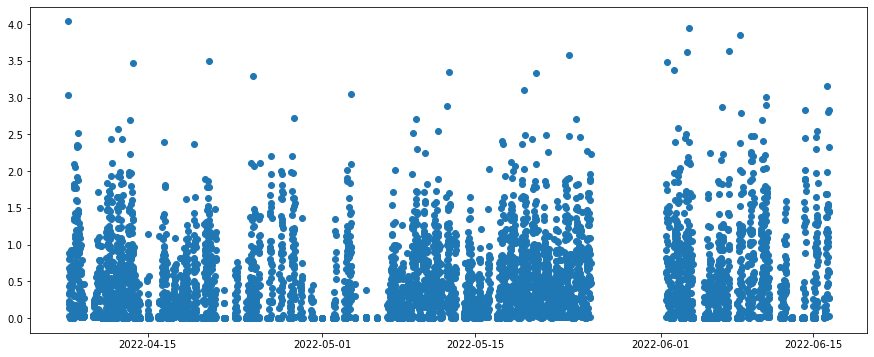

In [48]:
# example plot
filtered_data = data.loc[(data['lat_merc_x'] == 589993.30) &(data['lon_merc_x'] == 8489337.03)]

plt.figure(figsize=(15,6))
plt.plot_date(filtered_data['msgtime'],filtered_data['sog_mean'])

<AxesSubplot:xlabel='aisclass_count'>

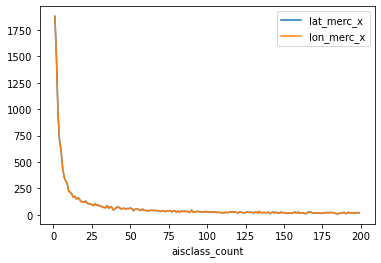

In [49]:
# anzahl der bereiche die nur eine geringe anzahl von messungen haben
meta = data[['lat_merc_x','lon_merc_x','aisclass_count']].groupby(['lat_merc_x','lon_merc_x']).sum().sort_values(['aisclass_count'],ascending=False).reset_index()
meta[meta['aisclass_count'] < 200].groupby(['aisclass_count']).count().plot()

## create interactive visuals on aggregated data

In [50]:
data.head()

,aisclass_count,aisclass_count_l_hour,date,dow,hod,lat_merc_x,lat_merc_y,lon_merc_x,lon_merc_y,mmsi_nunique,mmsi_nunique_l_hour,msgtime,sog_max,sog_max_l_hour,sog_mean,sog_mean_l_hour,sog_min,sog_min_l_hour,sog_std,sog_std_l_hour
0,1,0.00,2022-04-07,3,0,623389.15,623389.15,8202032.19,8202032.19,1,0.00,2022-04-07,1.10,0.00,1.10,0.00,1.10,0.00,0.00,0.00
1,1,0.00,2022-04-07,3,0,634521.10,634521.10,8267349.13,8267349.13,1,0.00,2022-04-07,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,1,0.00,2022-04-07,3,0,667916.94,667916.94,8267349.13,8267349.13,1,0.00,2022-04-07,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,1,0.00,2022-04-07,3,0,712444.74,712444.74,8311215.71,8311215.71,1,0.00,2022-04-07,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,1,0.00,2022-04-07,3,0,1135458.81,1135458.81,8333246.94,8333246.94,1,0.00,2022-04-07,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [51]:

visual_df = data[['lat_merc_x','lon_merc_x','msgtime','mmsi_nunique']]


In [52]:
visual_df.head()

,lat_merc_x,lon_merc_x,msgtime,mmsi_nunique
0,623389.15,8202032.19,2022-04-07,1
1,634521.10,8267349.13,2022-04-07,1
2,667916.94,8267349.13,2022-04-07,1
3,712444.74,8311215.71,2022-04-07,1
4,1135458.81,8333246.94,2022-04-07,1


In [100]:
output_file("visuals_base.html")
visual = visual_df[['lat_merc_x','lon_merc_x','mmsi_nunique']][visual_df['msgtime'] == '2022-04-17 11:20:00']
p = visualize_top_regions(visual)
show(p)

In [101]:
visual_df[['lat_merc_x','lon_merc_x','mmsi_nunique']][visual_df['msgtime'] == '2022-04-17 11:20:00'].sort_values('mmsi_nunique',ascending=False)

,lat_merc_x,lon_merc_x,mmsi_nunique
6206612,589993.30,8489337.03,55
6197947,2115070.33,10971767.97,39
6191843,634521.10,8180386.89,34
6186999,857160.08,9124813.24,31
6183964,1191118.55,8377507.56,27
...,...,...,...
1797648,1424889.48,10242060.79,1
1797657,1525077.02,10299995.50,1
1797664,1569604.82,10184607.52,1
1797666,1580736.77,10213274.52,1


## visualize avg. number of ships per day of week

In [106]:
output_file("visuals_dow.html")
visual = data[['lat_merc_x', 'lon_merc_x','mmsi_nunique','dow']][(visual_df['lat_merc_x'] == 589993.30) & (visual_df['lon_merc_x'] == 8489337.03)]
visual = visual.groupby(['dow']).mean().reset_index()
# create timeline visual
visual.head()
p = bar_chart(visual)
show(p)

         dow  lat_merc_x  lon_merc_x  mmsi_nunique
0     Monday   589993.30  8489337.03         43.07
1    Tuesday   589993.30  8489337.03         44.35
2  Wednesday   589993.30  8489337.03         43.63
3   Thursday   589993.30  8489337.03         41.66
4     Friday   589993.30  8489337.03         43.16
5   Saturday   589993.30  8489337.03         48.32
6     Sunday   589993.30  8489337.03         44.70


## visualize avf number of ships per hour of day

In [ ]:
output_file("visuals_hod.html")

## weitere visualisierungsideen

* time line von ausgewählten standorten zu den verschiedenen dimensionen
* weitere feature Ideen:
  * abbildung der werte für den aktuellen Zeitpunkt aus der Vergangenheit -> ermöglicht die Abbildung der zeitlichen Entwicklung als Feature
* Mögliche Algorithemn ( neues NB):
  * Isolation Forest
  * DB Scan
  * k-NN
  * Local Outlier Factory